In [117]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import pickle
from sklearn.model_selection import cross_val_score

In [118]:
df1 = pd.read_csv("df1.csv")
df2 = pd.read_csv("df2.csv")
df3 = pd.read_csv("df3.csv")
df4 = pd.read_csv("df4.csv")
df5 = pd.read_csv("df5.csv")

In [119]:
#merging all the data frames 
df1.drop(["Unnamed: 0","12"], inplace = True, axis = 1)
df2.drop(["Unnamed: 0","12"], inplace = True, axis = 1)
df3.drop(["Unnamed: 0"], inplace = True, axis = 1)
df4.drop(["Unnamed: 0"], inplace = True, axis = 1)
df5.drop(["Unnamed: 0"], inplace = True, axis = 1)
df = pd.concat([df1,df2,df3,df4,df5])

In [120]:
df.shape

(4988, 12)

In [121]:
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11
0,Go First,G8-392,12:45,New Delhi,15:00,Mumbai,2h 15m,Non Stop,"5,954",View Fares,24,1.0
1,Go First,G8-336,14:20,New Delhi,16:35,Mumbai,2h 15m,Non Stop,"5,954",View Fares,24,1.0
2,Go First,G8-323,18:05,New Delhi,20:25,Mumbai,2h 20m,Non Stop,"5,954",View Fares,24,1.0
3,Go First,G8-717/537,16:45,New Delhi,21:25,Mumbai,4h 40m,1 Stop,"4 left at5,954",View Fares,24,1.0
4,Go First,G8-167/388,15:00,New Delhi,21:55,Mumbai,6h 55m,1 Stop,"2 left at5,954",View Fares,24,1.0


In [122]:
#df.drop(["Unnamed: 0"], inplace = True, axis = 1)
df.drop(["9"], inplace = True, axis = 1)
columns = ["airline","flight","dep","source","arr","des","duration","stops","price","date","month"]
df.columns = columns

## EDA and Preprocessing

In [123]:
df.dtypes

airline      object
flight       object
dep          object
source       object
arr          object
des          object
duration     object
stops        object
price        object
date         object
month       float64
dtype: object

As we can clearly see that the price column has data type object which needs to be integer or float. Also, the data in the price column is also not cleaned. First we have to clean and then we convert it into a number from string.

In [124]:
df.isnull().sum()

airline     4
flight      0
dep         0
source      4
arr         4
des         4
duration    4
stops       4
price       4
date        4
month       8
dtype: int64

In [125]:
#df = df.fillna("mode")
df = df.dropna()
df.shape

(4980, 11)

there were only 8 null values. It is a very small fraction of the data so we have fill the data with mode.

The time given in the departure column and arrival column, we can find the hour of the day.

In [126]:
df["dep_hour"] = pd.to_datetime(df["dep"]).dt.hour
df["dep_min"] = pd.to_datetime(df["dep"]).dt.minute

Now we can drop the departure column.

In [127]:
df = df.drop(["dep"], axis = 1)

Similarly for the arival time.

In [128]:
df["arr_hour"] = pd.to_datetime(df["arr"]).dt.hour
df["arr_min"] = pd.to_datetime(df["arr"]).dt.minute
# dropping the arrival column
df = df.drop(["arr"], axis = 1)

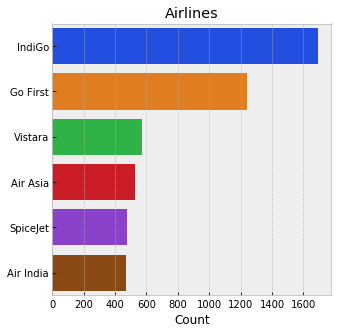

In [129]:
Airlines = df['airline'].value_counts()

plt.figure(figsize=(5, 5))
plt.tick_params(labelsize=10)
sns.barplot( Airlines.values,Airlines.index, palette='bright')
plt.title('Airlines')
plt.xlabel('Count')
plt.style.use('bmh')
plt.tick_params(labelsize=10)
plt.show()

In [130]:
df['stops'].value_counts()

Non Stop     2872
1 Stop       1965
2 Stop(s)      77
2h 10m         26
3 Stop(s)      21
6h 05m          9
4 Stop(s)       3
26h 50m         1
21h 40m         1
10h 25m         1
18h 20m         1
21h 50m         1
14h 35m         1
24h 10m         1
Name: stops, dtype: int64

There are maximum three stops in a flight journey. But we can see that there are some very weird values which are present due to column shifting during web scraping. An example of such column shown in below. Since the value of price is missing in these types of columns. Therefore these columns are not usefull for us. We have to drop those columns.

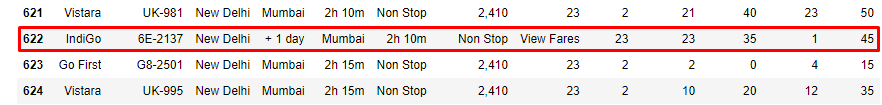

In [131]:
df = df[df["date"]!="View Fares"]

In [132]:
df.shape

(4938, 13)

There were 42 defected rows in which columns have been shifted as shown in the diagram above.

In [133]:
df['stops'].value_counts()

Non Stop     2872
1 Stop       1965
2 Stop(s)      77
3 Stop(s)      21
4 Stop(s)       3
Name: stops, dtype: int64

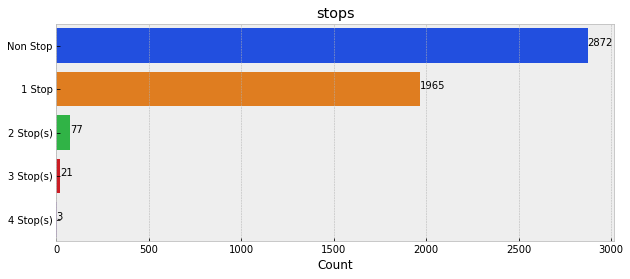

In [134]:
stops = df['stops'].value_counts()

plt.figure(figsize=(10, 4))
plt.tick_params(labelsize=10)
sns.barplot( stops.values,stops.index, palette='bright')
plt.title('stops')
plt.xlabel('Count')
plt.style.use('bmh')
plt.tick_params(labelsize=10)
index = ["Non stop", "1 stop", "2 stops", "3 stops"]
for index, value in enumerate(stops):
    plt.text(value, index,
             str(value))
plt.show()

In [135]:
df = df.replace({"Non Stop": 0, "1 Stop": 1, "2 Stop(s)": 2, "3 Stop(s)": 3, "4 Stop(s)": 4})

We have seen that the duration column has values in the format of "2h 45m" and some of the columns have format such as "7h" which is need to be comverted into a uniform format. Then we will convert it into such a format that can be used for machine learning. We will split this format into two different columns which will be hour and minutes.

In [136]:
duration = list(df["duration"])

for i in range(len(duration)):
    dur = duration[i]
    if len(dur.split()) != 2:                 # checking for the format
        if "h" in dur:
            duration[i] = dur.strip() + " 0m" # making the format uniform
        else:
            duration[i] = "0h " + dur         # making the format uniform
            
dur_hr = []
dur_min = []
for i in range(len(duration)):
    dur_hr.append(int(duration[i].split(sep = "h")[0]))                  # extracting hour 
    dur_min.append(int(duration[i].split(sep = "m")[0].split()[-1]))     # etracting min
    
# adding the data to dataframe
df["dur_hr"] = dur_hr
df["dur_min"] = dur_min

# dropping the original duration column
df.drop(["duration"], axis = 1, inplace = True)

The price column of data is not clean. We have to remove unnecessary information from that column and convert that column into int data type.

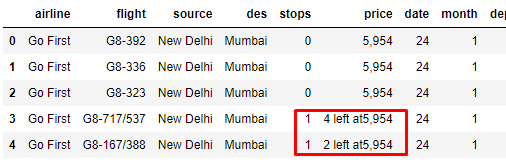

In [137]:
df.head()

,airline,flight,source,des,stops,price,date,month,dep_hour,dep_min,arr_hour,arr_min,dur_hr,dur_min
0,Go First,G8-392,New Delhi,Mumbai,0,"5,954",24,1.0,12,45,15,0,2,15
1,Go First,G8-336,New Delhi,Mumbai,0,"5,954",24,1.0,14,20,16,35,2,15
2,Go First,G8-323,New Delhi,Mumbai,0,"5,954",24,1.0,18,5,20,25,2,20
3,Go First,G8-717/537,New Delhi,Mumbai,1,"4 left at5,954",24,1.0,16,45,21,25,4,40
4,Go First,G8-167/388,New Delhi,Mumbai,1,"2 left at5,954",24,1.0,15,0,21,55,6,55


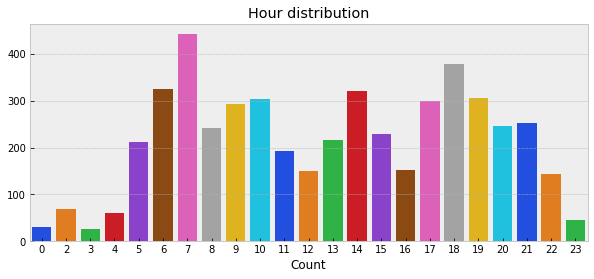

In [138]:
hrs = df['dep_hour'].value_counts()

plt.figure(figsize=(10, 4))
plt.tick_params(labelsize=10)
sns.barplot( hrs.index,hrs.values, palette='bright')
plt.title('Hour distribution')
plt.xlabel('Count')
plt.style.use('bmh')
plt.tick_params(labelsize=10)
plt.show()

It is clearly visible in the above graph that there are three peeks during the day. These peeks are at 7:00, 14:00 and 18:00. These times are belongs to early morning, mid of the day and evening. The number of flights is minimum in the midnight. Further we will also check the distribution of price with respect to the hour distribution.

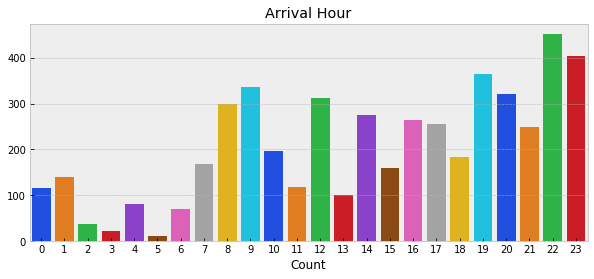

In [149]:
ahrs = df['arr_hour'].value_counts()

plt.figure(figsize=(10, 4))
plt.tick_params(labelsize=10)
sns.barplot( ahrs.index,ahrs.values, palette='bright')
plt.title('Arrival Hour')
plt.xlabel('Count')
plt.style.use('bmh')
plt.tick_params(labelsize=10)
plt.show()

In [139]:
price = list(df["price"])

for i in range(len(price)):
    if len(price[i]) > 5:             # checking if it is clean or not
        price[i] = int(price[i].split()[-1].replace("at","").replace(",","")) # extracting the price value & converting to int
    else:
        price[i] = int(price[i].replace(",","")) # convering into integer data type
        
# adding list into dataframe
df["price"] = price

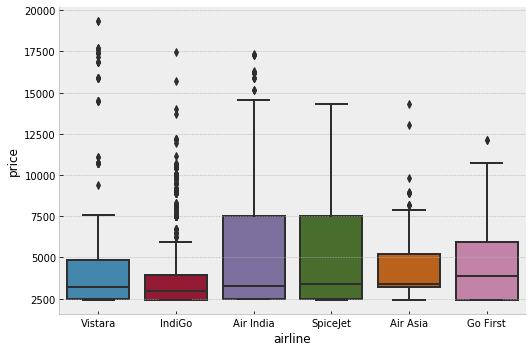

In [142]:
sns.catplot(y = "price", x = "airline", data = df.sort_values("price", ascending = False), kind="box", height = 5, aspect = 1.5)
plt.show()

Average price of the tickets is maximum in the case of Go First while the spread of price is maximum for Air India and Spicejet. On the other hand, the average price of Indigo is minimum. Vistara have most expensive flights that can reach upto a value of Rs. 19000.

In [102]:
df["date"] = pd.to_numeric(df["date"])

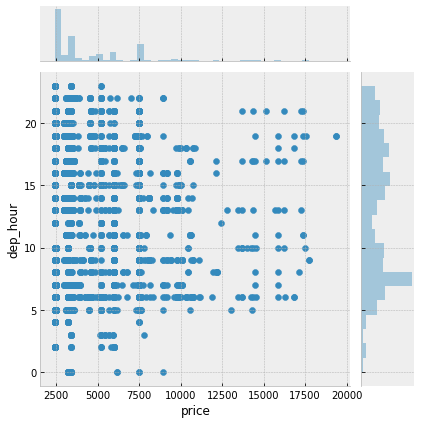

In [103]:
sns.jointplot(df["price"], df["dep_hour"])

Maximum number of flights are clustered below Rs. 7500 and their 7:00 hour has maximum number of flights than any other hour in the day.

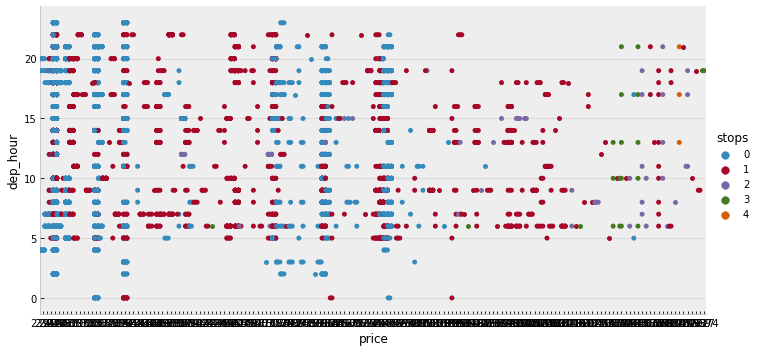

In [148]:
graph = sns.catplot(x="price", y="dep_hour", hue="stops", kind="swarm", data=df, aspect = 2)
#graph.set_xticks(30)

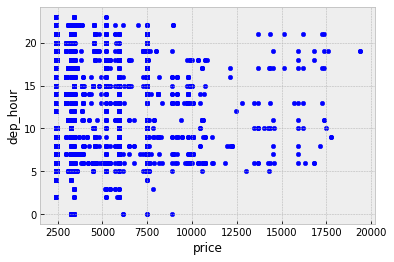

In [146]:
df.plot.scatter("price", "dep_hour")

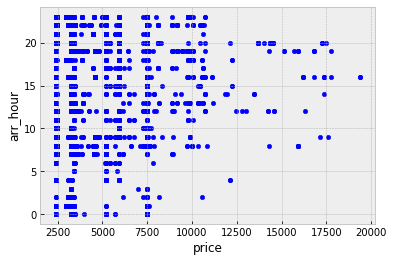

In [147]:
df.plot.scatter("price", "arr_hour")

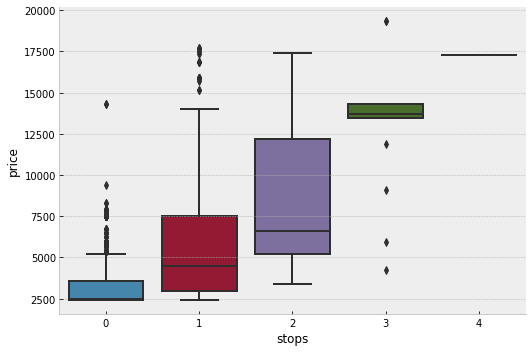

In [143]:
sns.catplot(y = "price", x = "stops", data = df.sort_values("price", ascending = False), kind="box", height = 5, aspect = 1.5)
plt.show()

Flights which are not non stop has time of departure clustered in during the day time and their price is hight. On the other hand the midnight flights are non stop and their price is relatively low.

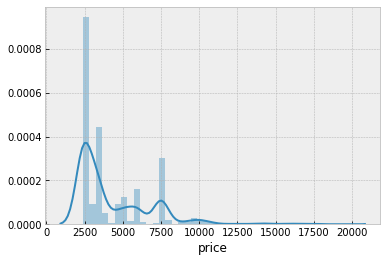

In [105]:
sns.distplot(df["price"])

In [106]:
df.head()

,airline,flight,source,des,stops,price,date,month,dep_hour,dep_min,arr_hour,arr_min,dur_hr,dur_min
0,Go First,G8-392,New Delhi,Mumbai,0,5954,24.0,1.0,12,45,15,0,2,15
1,Go First,G8-336,New Delhi,Mumbai,0,5954,24.0,1.0,14,20,16,35,2,15
2,Go First,G8-323,New Delhi,Mumbai,0,5954,24.0,1.0,18,5,20,25,2,20
3,Go First,G8-717/537,New Delhi,Mumbai,1,5954,24.0,1.0,16,45,21,25,4,40
4,Go First,G8-167/388,New Delhi,Mumbai,1,5954,24.0,1.0,15,0,21,55,6,55


In [107]:
# saving the cleaned data
df.to_csv("cleaned_data.csv")

In [108]:
airlines = df[["airline"]]
airlines = pd.get_dummies(airlines, drop_first = True)
df.drop(["flight"], axis = 1,inplace = True)
df.drop(["airline"], axis = 1, inplace = True)

In [109]:
source = df[["source"]]
source = pd.get_dummies(source, drop_first = True)
df.drop(["source"], axis = 1, inplace = True)

In [110]:
des = df[["des"]]
des = pd.get_dummies(des, drop_first = True)
df.drop(["des"], axis = 1, inplace = True)

In [111]:
df = pd.concat([df, airlines, source, des], axis = 1)

In [112]:
df.to_csv("final_data.csv")

### splitting the features and target

In [68]:
X = df.drop(["price"], axis = 1)
y = df["price"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

In [69]:
# extracting feature importance using extra tree regressor
from sklearn.ensemble import ExtraTreesRegressor
selection = ExtraTreesRegressor()
selection.fit(X,y)

ExtraTreesRegressor()

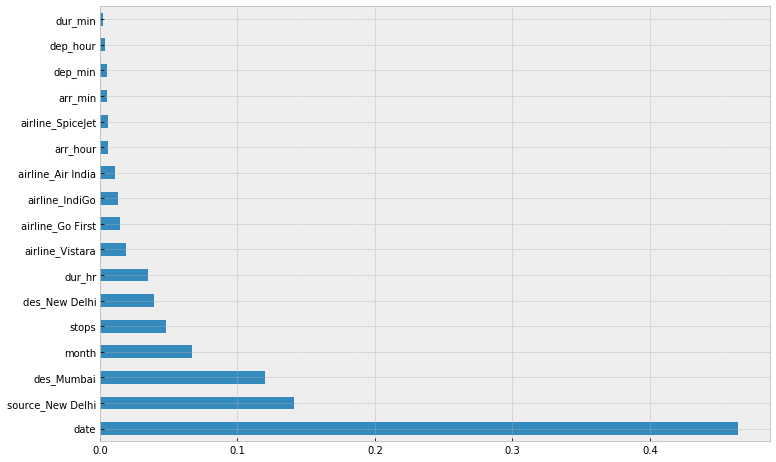

In [70]:
# plotting the feature importance 
plt.figure(figsize = (12,8))
feat_importances = pd.Series(selection.feature_importances_, index = X.columns)
feat_importances.nlargest(20).plot(kind = "barh")
plt.show()

## Linear Regression

In [144]:
#from sklearn.linear_model import LinearRegression
LR = LinearRegression()
LR.fit(X_train, y_train)
score = LR.score(X_test, y_test)
score

0.7595013487718469

In [76]:
scores = cross_val_score(LR, X_train, y_train, scoring = "r2", cv = 5)
scores

array([0.76590694, 0.739284  , 0.73664655, 0.76253945, 0.72283502])

## Decision Tree

In [118]:
from sklearn.tree import DecisionTreeRegressor
DT = DecisionTreeRegressor()
DT.fit(X_train, y_train)
score = DT.score(X_test, y_test)
score

0.9499829185314557

In [119]:
scores = cross_val_score(DT, X_train, y_train, scoring = "r2", cv = 5)
scores

array([0.94800582, 0.93512886, 0.95782273, 0.95828161, 0.97428561])

## Random Forest

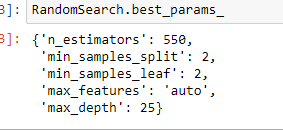

In [134]:
from sklearn.ensemble import RandomForestRegressor
RF = RandomForestRegressor(n_estimators = 550,
                           min_samples_split = 2,
                           min_samples_leaf = 2,
                           max_features = "auto",
                           max_depth = 25)
RF.fit(X_train, y_train)
accuracy = RF.score(X_test, y_test)
accuracy

0.9572271874709002

In [69]:
RF = RandomForestRegressor()

In [ ]:
RF()

In [121]:
scores = cross_val_score(DT, X_train, y_train, scoring = "r2", cv = 5)
scores

array([0.94507725, 0.93424998, 0.95268344, 0.95253357, 0.97496115])

## Gradient Boost

In [122]:
from sklearn.ensemble import GradientBoostingRegressor
GB = GradientBoostingRegressor(n_estimators = 80)
GB.fit(X_train, y_train)
accuracy = GB.score(X_test, y_test)
accuracy

0.9078047629199479

In [123]:
scores = cross_val_score(GB, X_train, y_train, scoring = "r2", cv = 5)
scores

array([0.92692851, 0.90282389, 0.90727527, 0.92030296, 0.93554635])

In [130]:
n_estimators = range(50,1000,50)
max_depth = range(5,30,5)
max_features = ["auto", "sqrt"]
min_sample_split = [2,5,10,20,50,100]
min_sample_leaf = [1,2,5,10]

param_dict = {
    "n_estimators":n_estimators,
    "max_depth":max_depth,
    "min_samples_split":min_sample_split,
    "min_samples_leaf":min_sample_leaf,
    "max_features":max_features,
}

from sklearn.model_selection import RandomizedSearchCV

RandomSearch = RandomizedSearchCV(estimator = RF, 
                                  param_distributions = param_dict,
                                  n_iter = 10, 
                                  cv = 5, 
                                  verbose=2,
                                  random_state=42,
                                  n_jobs=1)

In [131]:
RandomSearch.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=20, n_estimators=300; total time=   0.6s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=20, n_estimators=300; total time=   0.6s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=20, n_estimators=300; total time=   0.6s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=20, n_estimators=300; total time=   0.7s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=20, n_estimators=300; total time=   0.6s
[CV] END max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=550; total time=   3.4s
[CV] END max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=550; total time=   3.4s
[CV] END max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimator

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(n_estimators=80),
                   n_jobs=1,
                   param_distributions={'max_depth': range(5, 30, 5),
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 5, 10],
                                        'min_samples_split': [2, 5, 10, 20, 50,
                                                              100],
                                        'n_estimators': range(50, 1000, 50)},
                   random_state=42, verbose=2)

In [71]:
from sklearn.model_selection import GridSearchCV
param_dict = {
    "n_estimators":n_estimators,
    "max_depth":max_depth,
    "min_samples_split":min_samples_split,
    "min_samples_leaf":min_samples_leaf,
    "max_features":max_features,
}
grid_GB = GridSearchCV(RF,
                      param_grid=param_dict,
                      cv = 5,
                      verbose = 1,
                      n_jobs = -1)
grid_GB.fit(X_train, y_train)

Fitting 5 folds for each of 1440 candidates, totalling 7200 fits


GridSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'max_depth': range(5, 20),
                         'min_samples_leaf': range(1, 5),
                         'min_samples_split': range(2, 5),
                         'n_estimators': range(50, 200, 20)},
             verbose=1)

In [132]:
accuracy = RandomSearch.score(X_test, y_test)
accuracy

0.9573144160974417

In [133]:
RandomSearch.best_params_

{'n_estimators': 550,
 'min_samples_split': 2,
 'min_samples_leaf': 2,
 'max_features': 'auto',
 'max_depth': 25}

In [68]:
grid_GB.best_params_

{'max_depth': 9,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 90}

## Best model

Best model comes out to be the gradient boost with accuracy of 86%. We can save this model as a pkl file.

In [39]:
pickle.dump(grid_GB, open("LR_model.pkl", 'wb'))

### Applying the best model to test set